In [1]:
import data_utils as dutils
import model_utils as mutils
import numpy as np
import torch
import distributions as distr
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy
%load_ext autoreload
%autoreload 2

embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


/Users/user1/Documents/code/OBED/data_utils.py:390: UserWarning: Eventually need to adjust d_border.
  warnings.warn('Eventually need to adjust d_border.')


1/10000: elbo = -13856.733398
51/10000: elbo = -9398.438477
101/10000: elbo = -5660.739746
151/10000: elbo = -3312.453613
201/10000: elbo = -3045.853027
251/10000: elbo = -3351.061035
301/10000: elbo = -3114.981934
351/10000: elbo = -2939.289062
401/10000: elbo = -2968.403564
451/10000: elbo = -2890.123535
501/10000: elbo = -2759.527100
551/10000: elbo = -2807.479248
601/10000: elbo = -2618.927246
651/10000: elbo = -2606.213867
701/10000: elbo = -2474.984375
751/10000: elbo = -2580.084473
801/10000: elbo = -2402.147217
851/10000: elbo = -2401.609619
901/10000: elbo = -2349.210205
951/10000: elbo = -2224.821289
1001/10000: elbo = -2316.760742
1051/10000: elbo = -2151.946533
1101/10000: elbo = -2160.167725
1151/10000: elbo = -2000.197388
1201/10000: elbo = -2098.857910
1251/10000: elbo = -1934.108887
1301/10000: elbo = -1913.254761
1351/10000: elbo = -1862.791626
1401/10000: elbo = -1821.173462
1451/10000: elbo = -1817.704224
1501/10000: elbo = -1721.875732
1551/10000: elbo = -1607.35620

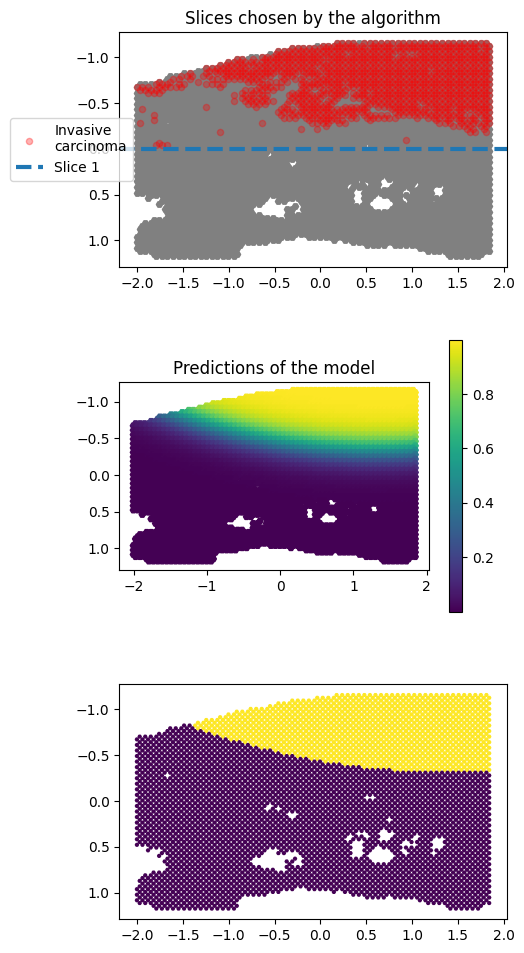

In [59]:
# posterior if all data observed

# data
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 70 # select full data with one slice
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_discrete(X, y, slice_radius = slice_radius)
tissue.execute_design({'slope':torch.tensor(0.0), 'intercept':torch.tensor(0.0)})

# fit variational model
r_prior = torch.tensor([1.0])
mu = torch.tensor([torch.log(r_prior),0.,0.,0.])
std = torch.tensor([1.,10.,10.,1.])
prior = distr.Circle_prior_log(mu=mu,log_std=torch.log(std))
predictive = distr.Circle_predictive()
guide = deepcopy(prior)
obs_data = tissue.get_obs_data()
var_distr = mutils.variational_inference(
    obs_data, prior, predictive, guide, with_previous_prior=False, n_steps_varinf=10000
)

# visual check
eval_y,eval_design = tissue.get_eval_data()
thetasMAP = var_distr.predict_mle()
preds = predictive.predict_mle(eval_design, thetasMAP)
print(f'radius: {(thetasMAP[0][0])}, center: {thetasMAP[0][1:]}')
tissue.verbose_designs(eval_design, preds.detach().cpu().numpy())

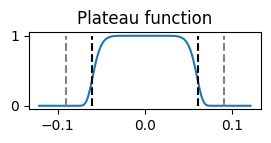

------- Iteration 1/3 -------


/Users/user1/Documents/code/OBED/model_utils.py:260: UserWarning: No optim steps! Checking variance of grad
  warnings.warn('No optim steps! Checking variance of grad')
100%|██████████| 60/60 [00:23<00:00,  2.56it/s]


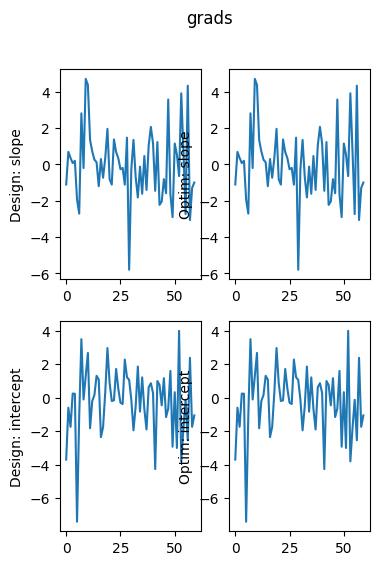

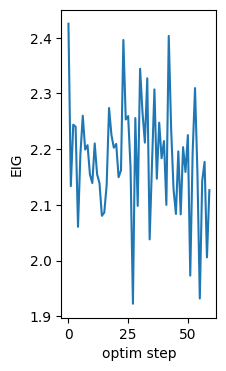

Executed design; best_eig: 2.126302719116211, design_params: {'slope': tensor(-0.2721, requires_grad=True), 'intercept': tensor(0.0610, requires_grad=True)}


100%|██████████| 1000/1000 [00:12<00:00, 82.15it/s]


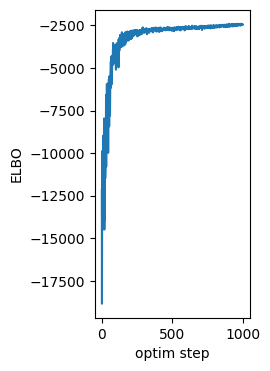

thetas_MAP: tensor([[ 1.0515,  2.7556, -3.4091,  0.2466]])


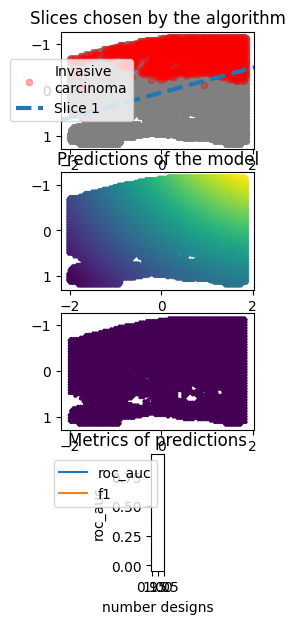

/Users/user1/Documents/code/OBED/model_utils.py:260: UserWarning: No optim steps! Checking variance of grad
  warnings.warn('No optim steps! Checking variance of grad')


------- Iteration 2/3 -------


100%|██████████| 60/60 [00:19<00:00,  3.01it/s]


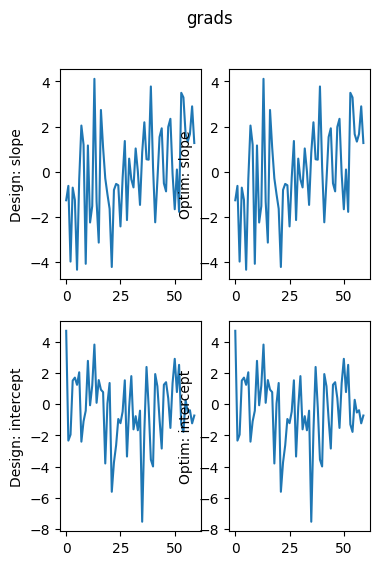

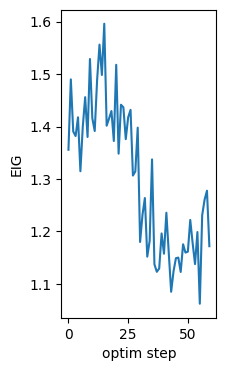

Executed design; best_eig: 1.1719508171081543, design_params: {'slope': tensor(0.8781, requires_grad=True), 'intercept': tensor(0.8573, requires_grad=True)}


100%|██████████| 1000/1000 [00:09<00:00, 110.97it/s]


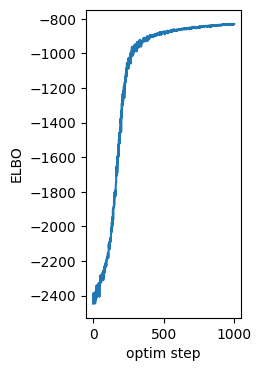

thetas_MAP: tensor([[ 4.2559,  0.8339, -4.5475,  7.2062]])


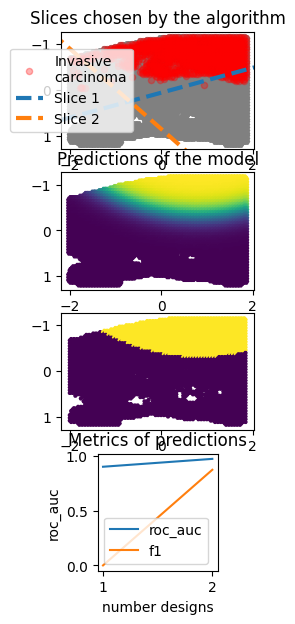

/Users/user1/Documents/code/OBED/model_utils.py:260: UserWarning: No optim steps! Checking variance of grad
  warnings.warn('No optim steps! Checking variance of grad')


------- Iteration 3/3 -------


100%|██████████| 60/60 [00:16<00:00,  3.65it/s]


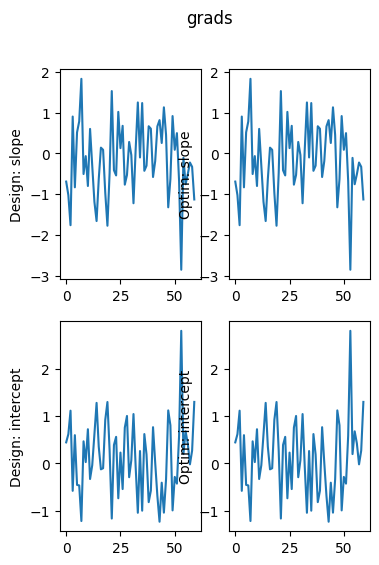

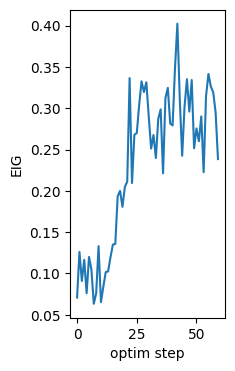

Executed design; best_eig: 0.23845607042312622, design_params: {'slope': tensor(1.1874, requires_grad=True), 'intercept': tensor(0.5957, requires_grad=True)}


100%|██████████| 1000/1000 [00:12<00:00, 78.19it/s]


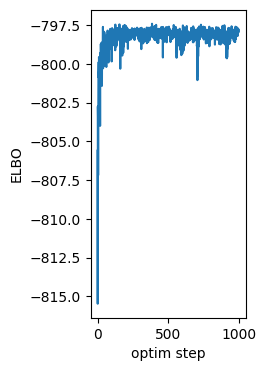

thetas_MAP: tensor([[ 4.2590,  0.8373, -4.5595,  7.2040]])


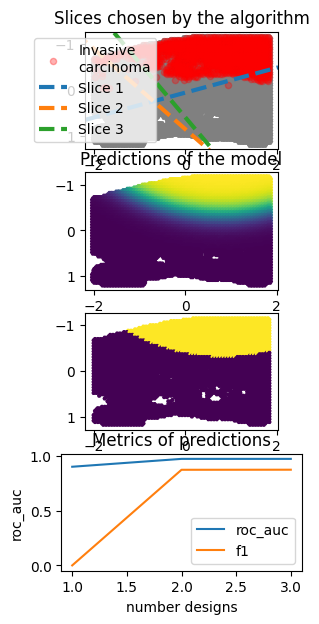

In [2]:
# continuous optim with continuous indicator (WORKING)
# data
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 2
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_cont_indicator(X, y, slice_radius)

# distributions
r_prior = torch.tensor([4.0])
temp_prior = torch.tensor([1.0])
mu = torch.tensor([torch.log(r_prior),0.,0., torch.log(temp_prior) ])
std = torch.tensor([1.,10.,10.,1.])
prior = distr.Circle_prior(mu=mu,std=std)
predictive = distr.Circle_predictive(with_weights=True)

# optimization
eig_method = mutils.eig_PCE
eig_optim_method = mutils.eig_cont_optim
optim_args = {
    'intercept': ('minmax', -2.0, 2.0),
    'slope': ('minmax', -10.0, 10.0),
}

# main execution
n_designs = 3
experiment, thetas_MAP, metric_values, metric_names = mutils.OED_fit(
    tissue, prior,predictive,n_designs,eig_method,eig_optim_method,
    print_every=50, verbose='plot',

    # eig optim
    n_steps_optim = 60,
    optim_args = {},

    # eig method
    n_outer = 200,
    n_inner = 100,

    # variaional inference
    n_steps_varinf=1000,
)

/Users/user1/Documents/code/OBED/data_utils.py:390: UserWarning: Eventually need to adjust d_border.
  warnings.warn('Eventually need to adjust d_border.')


------- Iteration 1/4 -------


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


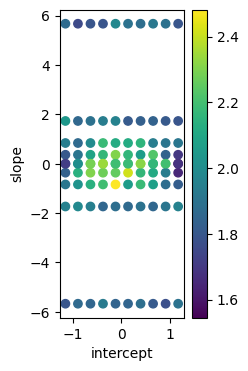

Executed design; best_eig: 2.4818644523620605, design_params: {'slope': tensor(-0.8391), 'intercept': tensor(-0.1200)}


  0%|          | 5/1500 [00:00<00:31, 47.27it/s]

1/1500: elbo = -823.992065


  4%|▎         | 56/1500 [00:01<00:27, 52.30it/s]

51/1500: elbo = -383.384338


  7%|▋         | 110/1500 [00:02<00:27, 49.71it/s]

101/1500: elbo = -216.432953


 10%|█         | 156/1500 [00:03<00:27, 49.53it/s]

151/1500: elbo = -205.477737


 14%|█▍        | 210/1500 [00:04<00:25, 50.48it/s]

201/1500: elbo = -170.291672


 17%|█▋        | 258/1500 [00:05<00:23, 52.83it/s]

251/1500: elbo = -175.017441


 20%|██        | 306/1500 [00:06<00:23, 51.89it/s]

301/1500: elbo = -163.061981


 24%|██▍       | 360/1500 [00:07<00:21, 52.38it/s]

351/1500: elbo = -161.624527


 27%|██▋       | 408/1500 [00:08<00:21, 50.93it/s]

401/1500: elbo = -162.724838


 30%|███       | 456/1500 [00:08<00:20, 51.73it/s]

451/1500: elbo = -154.900543


 34%|███▍      | 510/1500 [00:09<00:18, 53.26it/s]

501/1500: elbo = -157.102493


 37%|███▋      | 558/1500 [00:10<00:18, 50.89it/s]

551/1500: elbo = -154.718399


 40%|████      | 606/1500 [00:11<00:16, 52.60it/s]

601/1500: elbo = -150.431458


 44%|████▍     | 660/1500 [00:12<00:16, 50.28it/s]

651/1500: elbo = -145.236923


 47%|████▋     | 708/1500 [00:13<00:16, 48.30it/s]

701/1500: elbo = -148.346725


 50%|█████     | 753/1500 [00:14<00:16, 45.17it/s]

751/1500: elbo = -146.294479


 54%|█████▍    | 808/1500 [00:16<00:15, 43.96it/s]

801/1500: elbo = -144.426712


 57%|█████▋    | 860/1500 [00:17<00:13, 48.79it/s]

851/1500: elbo = -141.873764


 61%|██████    | 908/1500 [00:18<00:11, 50.24it/s]

901/1500: elbo = -146.157654


 64%|██████▎   | 956/1500 [00:19<00:10, 51.57it/s]

951/1500: elbo = -139.420410


 67%|██████▋   | 1010/1500 [00:20<00:09, 52.17it/s]

1001/1500: elbo = -140.646332


 71%|███████   | 1058/1500 [00:21<00:08, 52.56it/s]

1051/1500: elbo = -134.696030


 74%|███████▎  | 1106/1500 [00:22<00:07, 52.68it/s]

1101/1500: elbo = -131.139420


 77%|███████▋  | 1160/1500 [00:23<00:06, 51.85it/s]

1151/1500: elbo = -128.442871


 81%|████████  | 1208/1500 [00:24<00:05, 50.26it/s]

1201/1500: elbo = -123.246353


 84%|████████▎ | 1256/1500 [00:24<00:04, 52.63it/s]

1251/1500: elbo = -119.070511


 87%|████████▋ | 1310/1500 [00:26<00:03, 53.22it/s]

1301/1500: elbo = -111.363495


 91%|█████████ | 1358/1500 [00:26<00:02, 53.63it/s]

1351/1500: elbo = -102.705910


 94%|█████████▎| 1406/1500 [00:27<00:01, 53.22it/s]

1401/1500: elbo = -95.573990


 97%|█████████▋| 1456/1500 [00:28<00:00, 49.10it/s]

1451/1500: elbo = -92.135368


100%|██████████| 1500/1500 [00:29<00:00, 50.49it/s]


thetas_MAP: tensor([[ 1.6342,  1.5885, -1.3309,  1.9186]])


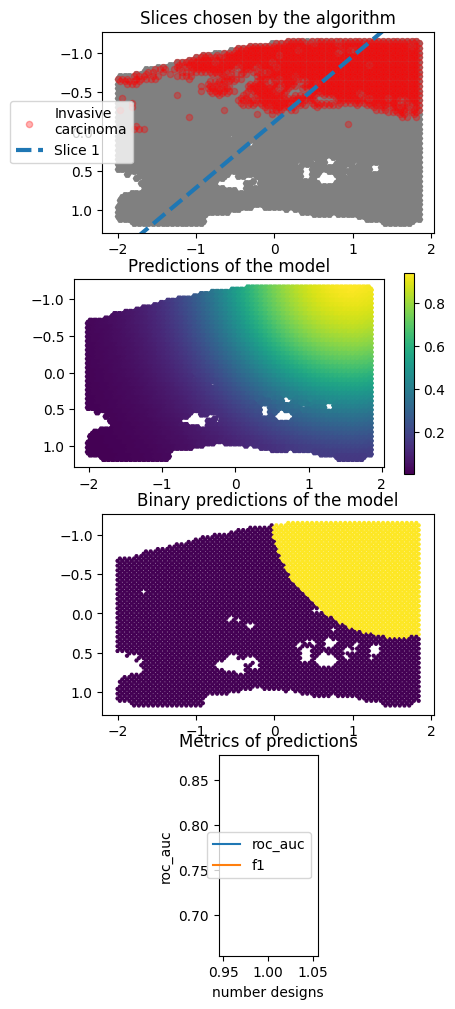

------- Iteration 2/4 -------


100%|██████████| 100/100 [01:15<00:00,  1.32it/s]


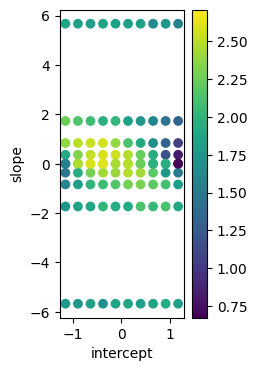

Executed design; best_eig: 2.7099030017852783, design_params: {'slope': tensor(0.), 'intercept': tensor(-0.6378)}


  0%|          | 5/1500 [00:00<00:30, 48.55it/s]

1/1500: elbo = -164.862473


  4%|▍         | 58/1500 [00:01<00:27, 53.30it/s]

51/1500: elbo = -123.912514


  7%|▋         | 106/1500 [00:02<00:27, 50.74it/s]

101/1500: elbo = -121.771454


 11%|█         | 158/1500 [00:03<00:26, 50.80it/s]

151/1500: elbo = -121.082642


 14%|█▎        | 206/1500 [00:04<00:25, 50.77it/s]

201/1500: elbo = -120.483681


 17%|█▋        | 260/1500 [00:05<00:23, 53.18it/s]

251/1500: elbo = -120.530258


 21%|██        | 308/1500 [00:05<00:22, 52.15it/s]

301/1500: elbo = -120.697922


 24%|██▎       | 356/1500 [00:06<00:22, 51.99it/s]

351/1500: elbo = -120.730331


 27%|██▋       | 410/1500 [00:07<00:21, 51.71it/s]

401/1500: elbo = -120.534538


 31%|███       | 458/1500 [00:08<00:20, 51.47it/s]

451/1500: elbo = -121.285278


 34%|███▎      | 506/1500 [00:09<00:19, 52.27it/s]

501/1500: elbo = -120.696518


 37%|███▋      | 560/1500 [00:10<00:18, 52.13it/s]

551/1500: elbo = -120.751808


 41%|████      | 608/1500 [00:11<00:16, 52.89it/s]

601/1500: elbo = -120.840248


 44%|████▎     | 656/1500 [00:12<00:17, 48.20it/s]

651/1500: elbo = -120.574730


 47%|████▋     | 710/1500 [00:13<00:14, 52.84it/s]

701/1500: elbo = -120.525169


 51%|█████     | 758/1500 [00:14<00:13, 53.38it/s]

751/1500: elbo = -120.886208


 54%|█████▎    | 806/1500 [00:15<00:13, 51.98it/s]

801/1500: elbo = -120.677620


 57%|█████▋    | 860/1500 [00:16<00:12, 52.48it/s]

851/1500: elbo = -120.497658


 61%|██████    | 908/1500 [00:17<00:11, 53.15it/s]

901/1500: elbo = -120.732498


 64%|██████▎   | 956/1500 [00:18<00:10, 52.19it/s]

951/1500: elbo = -120.878410


 67%|██████▋   | 1010/1500 [00:19<00:09, 51.92it/s]

1001/1500: elbo = -120.761375


 71%|███████   | 1058/1500 [00:20<00:08, 51.67it/s]

1051/1500: elbo = -120.652275


 74%|███████▎  | 1106/1500 [00:21<00:07, 53.11it/s]

1101/1500: elbo = -120.627899


 77%|███████▋  | 1160/1500 [00:22<00:06, 52.75it/s]

1151/1500: elbo = -120.819206


 81%|████████  | 1208/1500 [00:23<00:05, 53.58it/s]

1201/1500: elbo = -120.733681


 84%|████████▍ | 1261/1500 [00:24<00:04, 51.25it/s]

1251/1500: elbo = -120.800537


 87%|████████▋ | 1309/1500 [00:25<00:03, 51.34it/s]

1301/1500: elbo = -120.844460


 90%|█████████ | 1357/1500 [00:26<00:02, 51.71it/s]

1351/1500: elbo = -120.642662


 94%|█████████▍| 1410/1500 [00:27<00:01, 51.04it/s]

1401/1500: elbo = -120.260887


 97%|█████████▋| 1457/1500 [00:28<00:00, 47.93it/s]

1451/1500: elbo = -120.975517


100%|██████████| 1500/1500 [00:29<00:00, 51.72it/s]


thetas_MAP: tensor([[ 2.2001,  1.4742, -0.8779,  1.6806]])


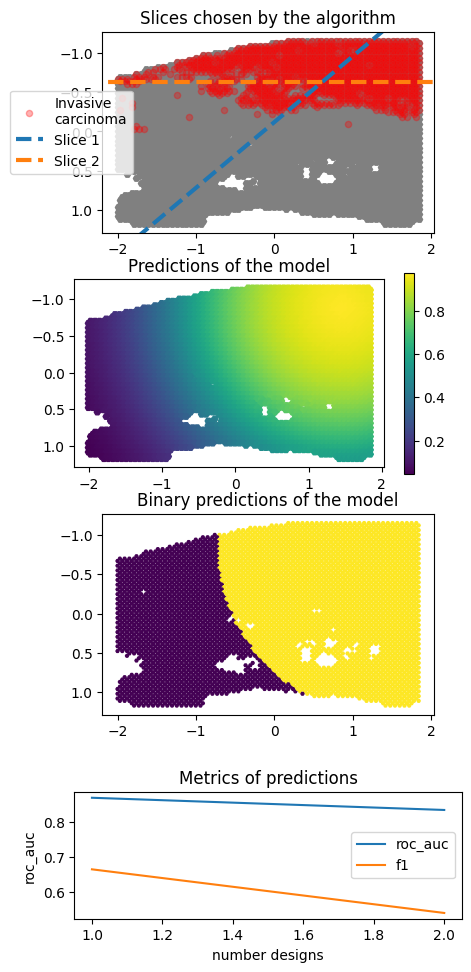

------- Iteration 3/4 -------


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


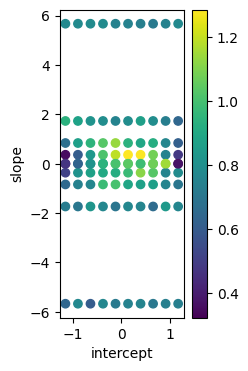

Executed design; best_eig: 1.2864799499511719, design_params: {'slope': tensor(0.3640), 'intercept': tensor(0.1390)}


  0%|          | 5/1500 [00:00<00:33, 44.05it/s]

1/1500: elbo = -239.705261


  4%|▍         | 58/1500 [00:01<00:28, 50.21it/s]

51/1500: elbo = -72.531708


  7%|▋         | 106/1500 [00:02<00:27, 50.65it/s]

101/1500: elbo = -36.083565


 11%|█         | 160/1500 [00:03<00:25, 51.56it/s]

151/1500: elbo = -32.747154


 14%|█▍        | 208/1500 [00:04<00:24, 52.32it/s]

201/1500: elbo = -32.837967


 17%|█▋        | 256/1500 [00:05<00:23, 52.31it/s]

251/1500: elbo = -31.747986


 21%|██        | 310/1500 [00:06<00:22, 52.90it/s]

301/1500: elbo = -30.617188


 24%|██▍       | 358/1500 [00:06<00:22, 51.38it/s]

351/1500: elbo = -30.284004


 27%|██▋       | 406/1500 [00:07<00:21, 50.67it/s]

401/1500: elbo = -29.328852


 31%|███       | 460/1500 [00:08<00:20, 51.56it/s]

451/1500: elbo = -30.130489


 34%|███▍      | 507/1500 [00:09<00:19, 50.20it/s]

501/1500: elbo = -29.985088


 37%|███▋      | 560/1500 [00:10<00:17, 52.23it/s]

551/1500: elbo = -29.456936


 41%|████      | 608/1500 [00:11<00:17, 51.28it/s]

601/1500: elbo = -28.181271


 44%|████▎     | 656/1500 [00:12<00:16, 52.64it/s]

651/1500: elbo = -28.317865


 47%|████▋     | 709/1500 [00:13<00:15, 52.37it/s]

701/1500: elbo = -27.626835


 50%|█████     | 757/1500 [00:14<00:14, 51.77it/s]

751/1500: elbo = -28.331066


 54%|█████▍    | 811/1500 [00:15<00:13, 52.55it/s]

801/1500: elbo = -26.394350


 57%|█████▋    | 859/1500 [00:16<00:12, 52.87it/s]

851/1500: elbo = -26.422892


 60%|██████    | 907/1500 [00:17<00:11, 51.71it/s]

901/1500: elbo = -27.626619


 64%|██████▍   | 961/1500 [00:18<00:10, 51.34it/s]

951/1500: elbo = -25.704496


 67%|██████▋   | 1009/1500 [00:19<00:09, 51.75it/s]

1001/1500: elbo = -25.225536


 70%|███████   | 1057/1500 [00:20<00:08, 51.58it/s]

1051/1500: elbo = -25.799250


 74%|███████▍  | 1110/1500 [00:21<00:07, 52.68it/s]

1101/1500: elbo = -26.781786


 77%|███████▋  | 1158/1500 [00:22<00:06, 52.47it/s]

1151/1500: elbo = -26.057293


 80%|████████  | 1206/1500 [00:23<00:05, 49.78it/s]

1201/1500: elbo = -26.024385


 84%|████████▍ | 1260/1500 [00:24<00:04, 51.21it/s]

1251/1500: elbo = -25.009062


 87%|████████▋ | 1308/1500 [00:25<00:03, 50.68it/s]

1301/1500: elbo = -24.137346


 90%|█████████ | 1356/1500 [00:26<00:02, 51.62it/s]

1351/1500: elbo = -25.595501


 94%|█████████▍| 1409/1500 [00:27<00:01, 51.16it/s]

1401/1500: elbo = -24.301693


 97%|█████████▋| 1457/1500 [00:28<00:00, 52.66it/s]

1451/1500: elbo = -23.035534


100%|██████████| 1500/1500 [00:29<00:00, 51.21it/s]


thetas_MAP: tensor([[ 0.6196,  1.7044, -3.3284,  1.7302]])


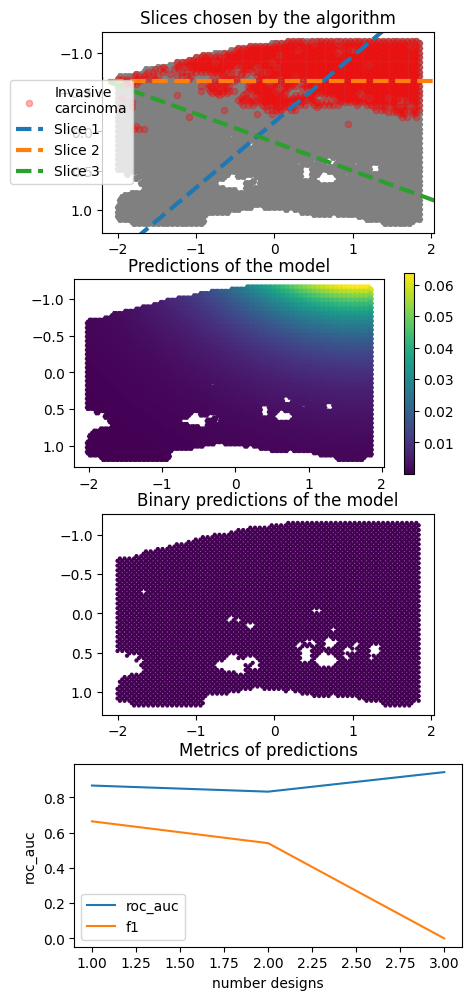

------- Iteration 4/4 -------


100%|██████████| 100/100 [01:12<00:00,  1.37it/s]


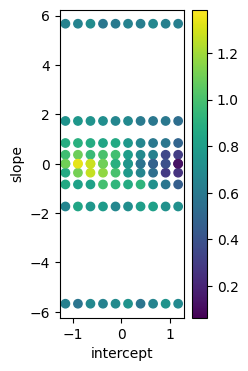

Executed design; best_eig: 1.3854979276657104, design_params: {'slope': tensor(0.), 'intercept': tensor(-0.8968)}


  0%|          | 5/1500 [00:00<00:32, 46.32it/s]

1/1500: elbo = -1221.502441


  4%|▍         | 58/1500 [00:01<00:27, 53.38it/s]

51/1500: elbo = -376.142548


  7%|▋         | 106/1500 [00:02<00:26, 53.47it/s]

101/1500: elbo = -195.792160


 11%|█         | 160/1500 [00:03<00:25, 52.85it/s]

151/1500: elbo = -189.828659


 14%|█▍        | 208/1500 [00:03<00:24, 53.41it/s]

201/1500: elbo = -111.899429


 17%|█▋        | 256/1500 [00:04<00:23, 53.49it/s]

251/1500: elbo = -101.545990


 21%|██        | 310/1500 [00:05<00:22, 52.80it/s]

301/1500: elbo = -52.257042


 24%|██▍       | 357/1500 [00:06<00:21, 51.96it/s]

351/1500: elbo = -48.761765


 27%|██▋       | 405/1500 [00:07<00:20, 52.99it/s]

401/1500: elbo = -49.573418


 31%|███       | 459/1500 [00:08<00:20, 51.35it/s]

451/1500: elbo = -45.177589


 34%|███▍      | 507/1500 [00:09<00:19, 51.90it/s]

501/1500: elbo = -43.412819


 37%|███▋      | 561/1500 [00:10<00:18, 51.19it/s]

551/1500: elbo = -43.892246


 41%|████      | 609/1500 [00:11<00:16, 52.72it/s]

601/1500: elbo = -44.014843


 44%|████▎     | 656/1500 [00:12<00:15, 52.88it/s]

651/1500: elbo = -44.748516


 47%|████▋     | 710/1500 [00:13<00:15, 52.01it/s]

701/1500: elbo = -42.191463


 51%|█████     | 758/1500 [00:14<00:14, 50.94it/s]

751/1500: elbo = -42.646885


 54%|█████▎    | 806/1500 [00:15<00:13, 50.88it/s]

801/1500: elbo = -42.019424


 57%|█████▋    | 860/1500 [00:16<00:12, 52.49it/s]

851/1500: elbo = -42.228741


 61%|██████    | 908/1500 [00:17<00:11, 52.90it/s]

901/1500: elbo = -42.976849


 64%|██████▎   | 956/1500 [00:18<00:10, 52.09it/s]

951/1500: elbo = -41.352562


 67%|██████▋   | 1010/1500 [00:19<00:09, 53.24it/s]

1001/1500: elbo = -41.488258


 71%|███████   | 1058/1500 [00:20<00:08, 52.99it/s]

1051/1500: elbo = -41.220081


 74%|███████▎  | 1106/1500 [00:21<00:07, 53.21it/s]

1101/1500: elbo = -41.899712


 77%|███████▋  | 1160/1500 [00:22<00:06, 52.93it/s]

1151/1500: elbo = -41.159107


 81%|████████  | 1208/1500 [00:23<00:05, 52.92it/s]

1201/1500: elbo = -41.830940


 84%|████████▎ | 1256/1500 [00:24<00:04, 53.19it/s]

1251/1500: elbo = -41.178215


 87%|████████▋ | 1310/1500 [00:25<00:03, 53.30it/s]

1301/1500: elbo = -41.590843


 91%|█████████ | 1358/1500 [00:26<00:02, 52.98it/s]

1351/1500: elbo = -40.755623


 94%|█████████▎| 1406/1500 [00:26<00:01, 53.19it/s]

1401/1500: elbo = -41.735844


 97%|█████████▋| 1460/1500 [00:27<00:00, 53.20it/s]

1451/1500: elbo = -41.665604


100%|██████████| 1500/1500 [00:28<00:00, 52.17it/s]


thetas_MAP: tensor([[ 7.0919,  1.0061, -1.7417,  0.7447]])


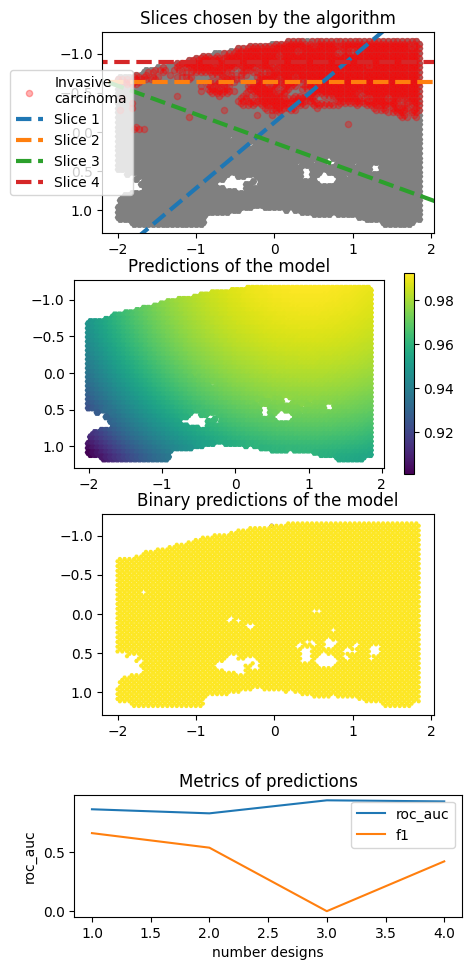

In [17]:
# discrete 

# data
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 2
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_discrete(X, y, slice_radius = slice_radius)
torch.autograd.set_detect_anomaly(True)

# distributions
r_prior = torch.tensor([4.0])
temp_prior = torch.tensor([1.0])
mu = torch.tensor([torch.log(r_prior),0.,0., torch.log(temp_prior) ])
std = torch.tensor([1.,10.,10.,1.])
prior = distr.Circle_prior(mu=mu,std=std)
predictive = distr.Circle_predictive()

# optimization
eig_method = mutils.eig_PCE
eig_optim_method = mutils.eig_discrete_optim
n_designs = 4

# execution
experiment, thetas_MAP, metric_values, metric_names = mutils.OED_fit(
    tissue, prior,predictive,n_designs,eig_method,eig_optim_method,
    print_every=50,

    n_steps_varinf=1500,
    n_outer = 500,
    n_inner = 200
)


------- Iteration 1/4 -------


  0%|          | 0/50 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


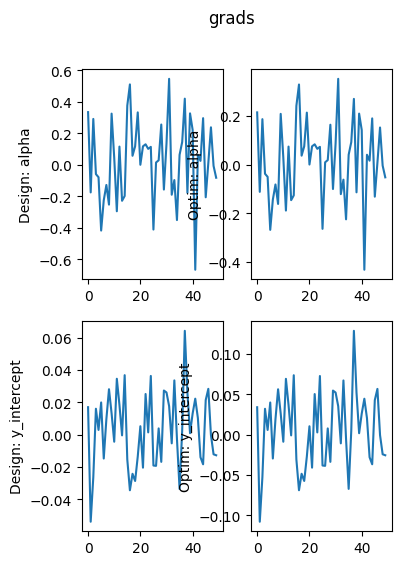

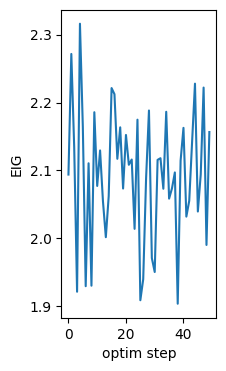

Executed design; best_eig: 2.1565682888031006, design_params: {'alpha': tensor(-0.0474, grad_fn=<AddBackward0>), 'y_intercept': tensor(-0.0031, grad_fn=<AddBackward0>)}


100%|██████████| 1000/1000 [00:19<00:00, 50.81it/s]


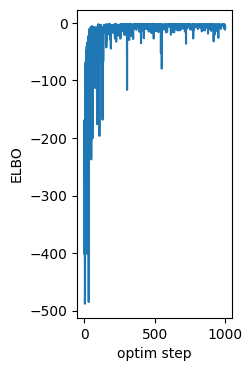

thetas_MAP: tensor([[ 1.1618,  0.1071, -0.0354,  1.2657]])
0.809117


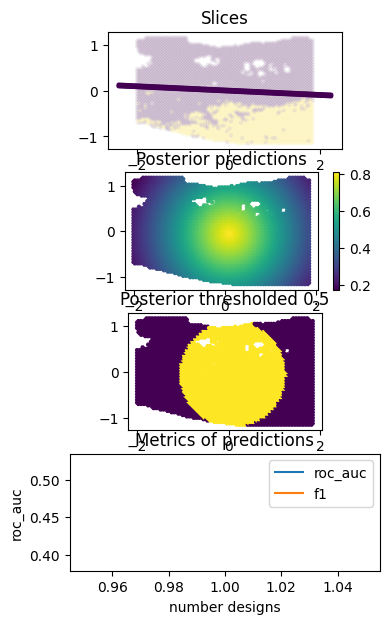

------- Iteration 2/4 -------


  0%|          | 0/50 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


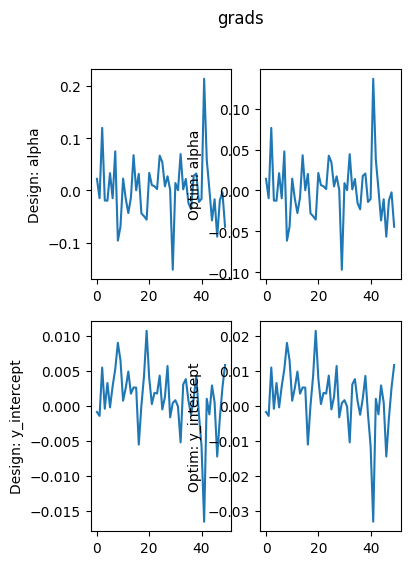

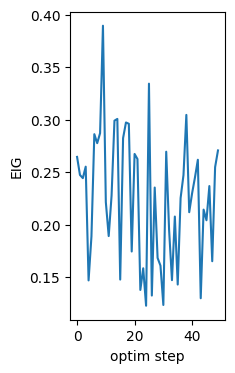

Executed design; best_eig: 0.2706241309642792, design_params: {'alpha': tensor(-0.0490, grad_fn=<AddBackward0>), 'y_intercept': tensor(-0.0070, grad_fn=<AddBackward0>)}


100%|██████████| 1000/1000 [00:19<00:00, 51.37it/s]


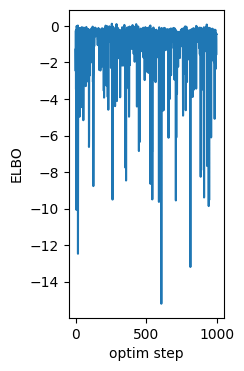

thetas_MAP: tensor([[ 0.9100, -0.0145, -0.2381,  1.4442]])
0.7848509


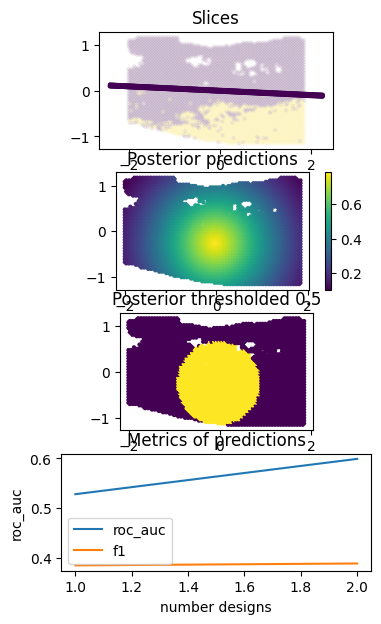

------- Iteration 3/4 -------


  0%|          | 0/50 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


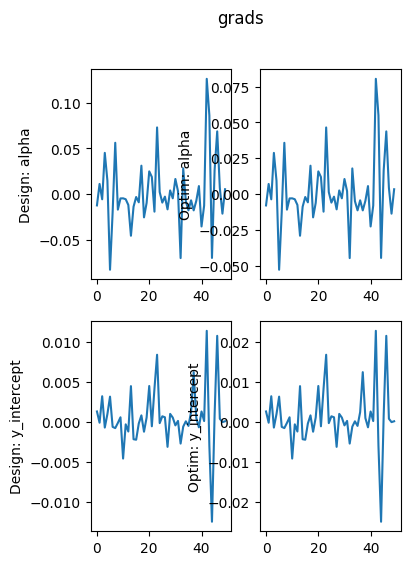

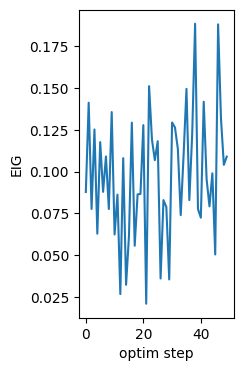

Executed design; best_eig: 0.10898628830909729, design_params: {'alpha': tensor(-0.0446, grad_fn=<AddBackward0>), 'y_intercept': tensor(-0.0077, grad_fn=<AddBackward0>)}


100%|██████████| 1000/1000 [00:19<00:00, 51.27it/s]


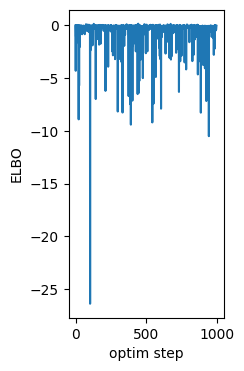

thetas_MAP: tensor([[ 0.8407, -0.1119, -0.1407,  1.5814]])
0.7856002


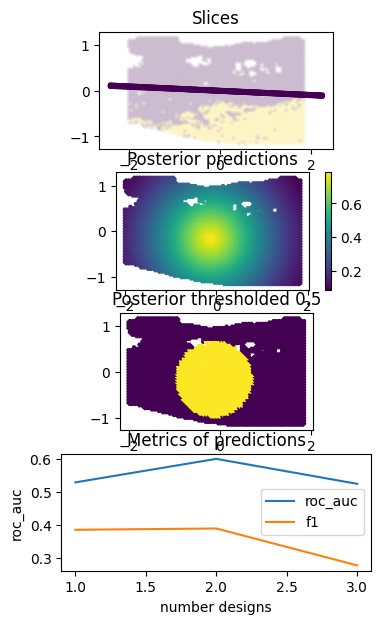

------- Iteration 4/4 -------


  0%|          | 0/50 [00:00<?, ?it/s]/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/user1/miniconda3/envs/py39/lib/python3.9/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


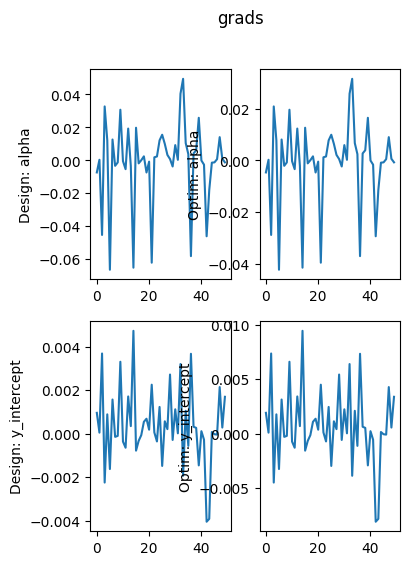

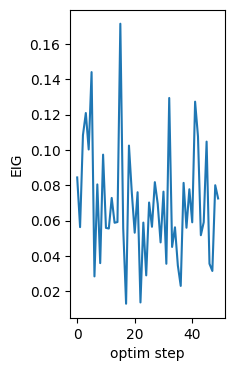

Executed design; best_eig: 0.07248000800609589, design_params: {'alpha': tensor(-0.0409, grad_fn=<AddBackward0>), 'y_intercept': tensor(-0.0087, grad_fn=<AddBackward0>)}


100%|██████████| 1000/1000 [00:19<00:00, 51.61it/s]


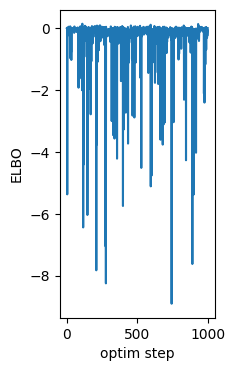

thetas_MAP: tensor([[ 0.8006, -0.5153,  0.1291,  1.6272]])
0.7816135


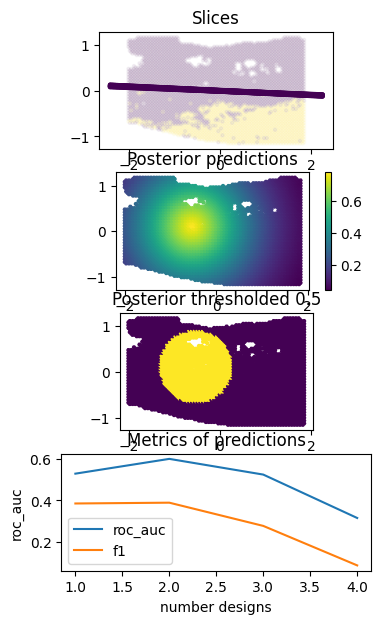

In [6]:
# continuous optim with completely continuous tissue

# data
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data()
tissue = dutils.Tissue_continuous(X, y, slice_radius = 1)
torch.autograd.set_detect_anomaly(True)

# distributions
r_prior = torch.tensor([3.0])
mu = torch.tensor([torch.log(r_prior),0.,0.,0.])
std = torch.tensor([1.,10.,10.,1.])
prior = distr.Circle_prior(mu=mu,std=std)
predictive = distr.Circle_predictive()

# optimization
eig_calc_method = mutils.eig_PCE
eig_optim_method = mutils.eig_cont_optim
optim_args = {
    'alpha': ('minmax', -torch.pi, torch.pi),
    'y_intercept': ('minmax', -1, 1),
}

# execution
n_designs = 4
experiment, thetas_MAP, metric_values, metric_names = mutils.OED_fit(
    tissue, prior,predictive,n_designs,eig_calc_method,eig_optim_method,
    print_every=50, verbose='plot',

    # eig optim
    n_steps_optim = 50,
    optim_args = optim_args,

    # eig method
    n_outer = 200,
    n_inner = 100,

    # variaional inference
    n_steps_varinf=1000,
)

/Users/user1/Documents/code/OBED/data_utils.py:390: UserWarning: Eventually need to adjust d_border.
  warnings.warn('Eventually need to adjust d_border.')
100%|██████████| 2000/2000 [01:12<00:00, 27.50it/s]


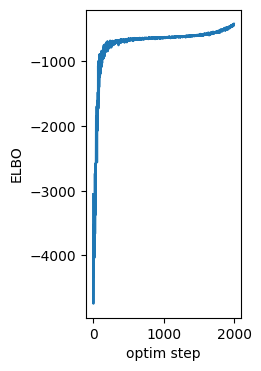

radius: 2.480421781539917, center: tensor([ 1.2870, -2.3981,  1.6004])


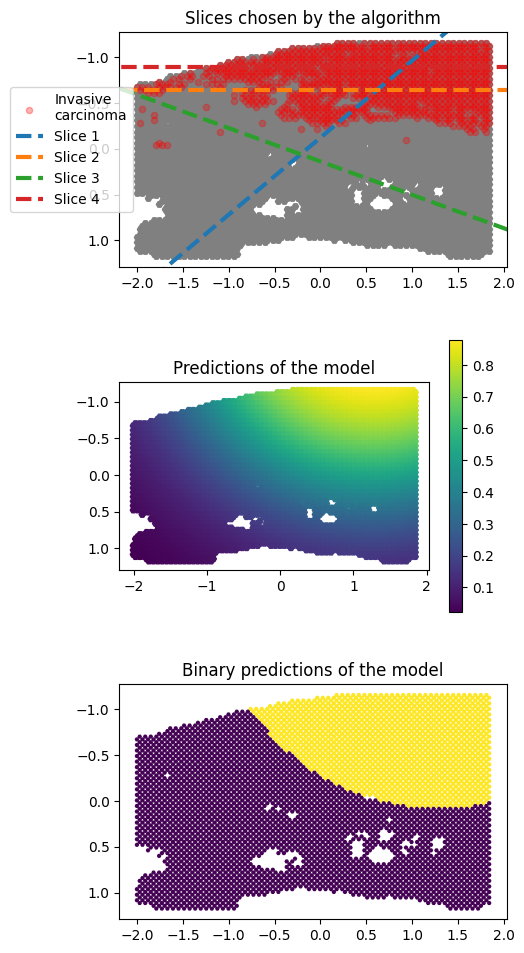

In [23]:
# posterior from some observed data
interesting_designs = None

# data
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 2 # select full data with one slice
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_discrete(X, y, slice_radius = slice_radius)
for d in interesting_designs:
    tissue.execute_design(d)

# fit variational model
r_prior = torch.tensor([1.0])
mu = torch.tensor([torch.log(r_prior),0.,0.,0.])
std = torch.tensor([1.,10.,10.,1.])
prior = distr.Circle_prior(mu=mu,std=std)
predictive = distr.Circle_predictive()
guide = deepcopy(prior)
obs_data = tissue.get_obs_data()
var_distr = mutils.variational_inference(
    obs_data, prior, predictive, guide, with_previous_prior=False, n_steps_varinf=2000,
    verbose='plot'
)

# visual check
eval_y,eval_design = tissue.get_eval_data()
thetasMAP = var_distr.predict_mle()
preds = predictive.predict_mle(eval_design, thetasMAP)
print(f'radius: {(thetasMAP[0][0])}, center: {thetasMAP[0][1:]}')
tissue.verbose_designs(eval_design, preds.detach().cpu().numpy())

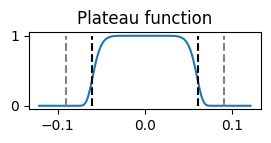

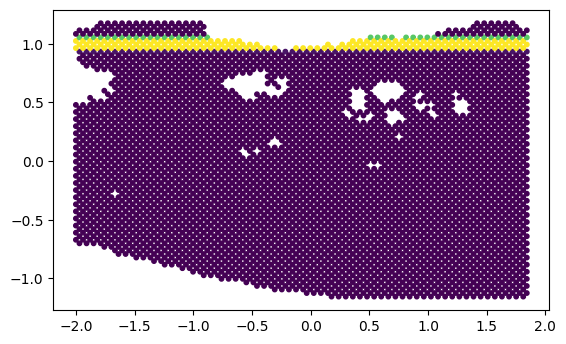

In [29]:
# check that distance is correct
datamodule = dutils.Prostate_cancer_2d()
X,y = datamodule.get_data(processed=True)
slice_radius_pixel = 2
slice_radius = slice_radius_pixel / datamodule.norm_params['std_both']
tissue = dutils.Tissue_cont_indicator(X, y, slice_radius)

design_params = {
    'slope': torch.tensor(0.0),
    'intercept': torch.tensor(1.0)
}
y,design = tissue.params2design(design_params)
plt.figure()
plt.scatter(design[:,1], design[:,2], c=design[:,0], s=10)
plt.gca().set_aspect('equal', adjustable='box')